<a href="https://colab.research.google.com/github/aayushrai/NLP/blob/master/Sentiment%20Analysis/Sentiment_Analysis(imdb)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Download imdb movie review dataset 

!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-04-09 13:14:22--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.6MB/s    in 7.4s    

2020-04-09 13:14:30 (10.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
!tar -xvzf /content/aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/44954_0.txt
aclImdb/train/unsup/4

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:
def read_data(base):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    for folder in ["train","test"]:
      for label in ["pos","neg"]:
        path = os.path.join(base,folder,label)
        for file_name in os.listdir(path):
          with open(os.path.join(path,file_name)) as review:
            if folder == "train":
              X_train.append(review.read())
              if label == "pos":
                Y_train.append(1)
              else:
                Y_train.append(0)
            elif folder == "test":
              X_test.append(review.read())
              if label == "pos":
                Y_test.append(1)
              else:
                Y_test.append(0)
    print("X_train ,Y_train :",len(X_train),len(Y_train))
    print("X_test ,Y_test:",len(X_test),len(Y_test))
    assert (len(X_train) == len(Y_train)),"X_train and Y_train length is not equal"
    assert (len(X_test) == len(Y_test)),"X_test and Y_test length is not equal"
    X_train,Y_train = shuffle(X_train,Y_train)
    X_test,Y_test = shuffle(X_test,Y_test)
    return X_train,Y_train,X_test,Y_test

In [5]:
base = "/content/aclImdb/"
X_train,Y_train,X_test,Y_test = read_data(base)

X_train ,Y_train : 25000 25000
X_test ,Y_test: 25000 25000


In [6]:
from bs4 import BeautifulSoup
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stemmer = PorterStemmer()
stopWords = set(stopwords.words('english'))

In [0]:
def review_to_words(review):
  soup = BeautifulSoup(review,"html5lib")
  text = "".join([text for text in soup.stripped_strings])
  for char in punctuation+"1234567890":
    text = text.replace(char," ")
  
  words = text.lower().split()

  filter_words = []
  for word in words:
    if word not in stopWords:
      filter_words.append(word)
  words = []
  for word in filter_words:
    words.append(stemmer.stem(word))
  return words

In [9]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        X_train, X_test, Y_train, Y_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(X_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(Y_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
"Still Crazy" is without a doubt the greatest rock comedy of all-time. It has been erroneously compared to "This Is Spinal Tap", which it has no relation to. "Spinal Tap" is a satire (and, quite frankly, not a very good one, in spite of it's "outing" of many rock clichés). Unlike "Tap", "Still Crazy" is populated by great actors, great songs and great human situations. You CARE about the people in "Still Crazy". That's all that matters. Oh, yeah, the music's pretty damn good, too, written by Mick Jones of Foreigner and Chris Difford of Squeeze. American audiences were already familiar with Stephen Rea (The Crying Game), but would only later become familiar with Bill Nighy (Underworld, Love Actually, Pirates Of The Caribbean II) and Timothy Spall (the Harry Potter movies).

--- Preprocessed words ---
['still', 'crazi', 'without', 'doubt', 'greatest', 'rock', 'comedi', 'time', 'erron', 'compar', 'spinal', 't

In [10]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray() #does a combined fit() and transform()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray() # only do transform on test set, use same fit parameters
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(Y_test[5])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['glad', 'streisand', 'varieti', 'bag', 'sissi', 'amazingli', 'miss', 'astound']

--- Preprocessed words ---
['spoiler', 'movi', 'concept', 'william', 'go', 'low', 'order', 'replay', 'footbal', 'game', 'haunt', 'life', 'russel', 'play', 'ex', 'jock', 'peak', 'high', 'school', 'final', 'dog', 'get', 'shot', 'william', 'save', 'face', 'instead', 'clown', 'great', 'revers', 'tragedi']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
0


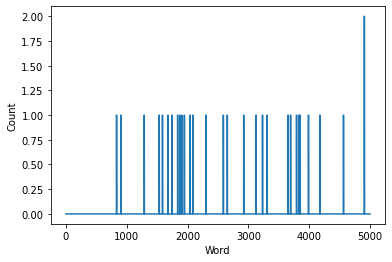

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

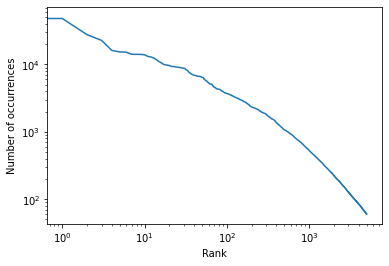

In [12]:
word_freq = features_train.sum(axis=0)
sorted_word_freq = np.sort(word_freq)[::-1]
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [0]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
#n_estimators = gsearch1.best_params_['n_estimators']
#n_estimators = gsearch1.best_params_['n_estimators']

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    # TODO(optional): Perform hyperparameter tuning / model selection
    gsearch = GridSearchCV(estimator = clf, param_grid = {'n_estimators': range(20, 81, 10)}, verbose=50, n_jobs=-1)
    gsearch.fit(X_train, y_train)
    clf = gsearch.best_estimator_
    print(gsearch.best_params_)

    
    # TODO: Print final training & test accuracy
    # Calculate the mean accuracy score on training and test sets
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf.__class__.__name__,
        clf.score(X_train[:], y_train[:]),
        clf.score(X_test[:], y_test[:])))
    # Return best classifier model
    return clf

clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.9

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done  33 out of  35 | elapsed: 38.2min remainin

In [25]:
words = [review_to_words("so bad")]
output = "pos"
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x:x, vocabulary=vocabulary)
print(words)
features_myreview =vectorizer.transform(words).toarray()

[['bad']]


In [26]:
#print(features_myreview)
features_myreview = pr.normalize(features_myreview)
#print(features_myreview)
# TODO: Then call your classifier to label it
clf2.predict(features_myreview)[0]

0